# Predecir el coste del seguro medico de una persona

- Importamos las librerias que vamos a utilizar

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

- Paso 1 Cargar el DataFrame que vamos a usar

In [3]:
ruta = r"C:\Users\Alia\Documents\ProyectoAPI\aliasys-machine-learning\data\raw\medical_insurance_cost.csv"

df = pd.read_csv(ruta)

In [4]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [5]:
df.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')

- Realizamos el EDA

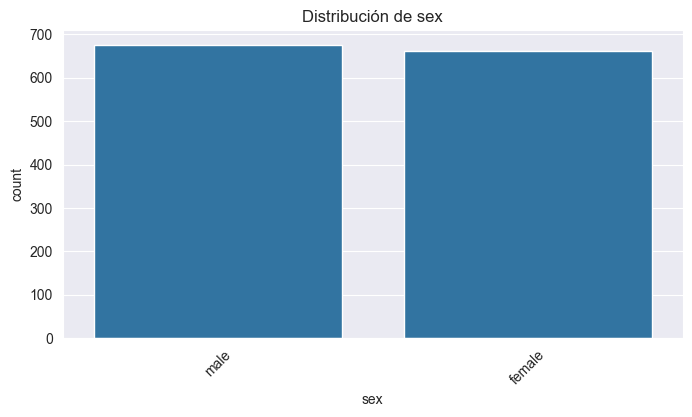

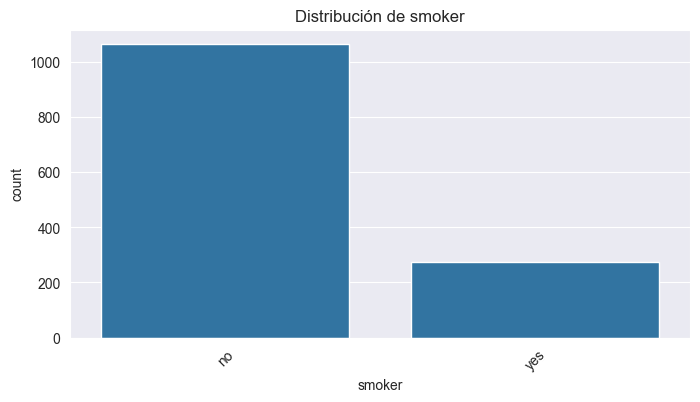

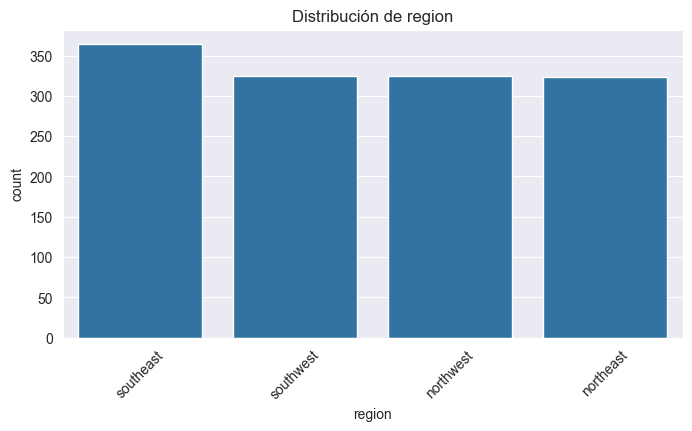

In [6]:
# Analisis de vaiables categóricas
categorical = df.select_dtypes(include='object').columns
for col in categorical:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=df, x=col, order=df[col].value_counts().index)
    plt.title(f'Distribución de {col}')
    plt.xticks(rotation=45)
    plt.show()

## Observaciones:

- **Sexo (`sex`)**:
  La variable sexo muestra poca diferencia en los costos médicos (`charges`). No es un factor determinante para predecir gastos, aunque puede tener ligeras variaciones.

- **Fumador (`smoker`)**:
  Es la variable categórica con **mayor impacto** en los costos médicos. Los fumadores presentan costos significativamente más altos que los no fumadores, lo que refleja los riesgos asociados al tabaquismo y su impacto en la salud.

- **Región (`region`)**:
  No se observan diferencias relevantes en los costos médicos según la región geográfica. Esto indica que la ubicación no influye de manera notable en los gastos de seguro médico en este dataset.

En resumen, **ser fumador es el factor categórico más importante** para explicar la variabilidad en los costos médicos, mientras que sexo y región tienen un efecto muy bajo o nulo.

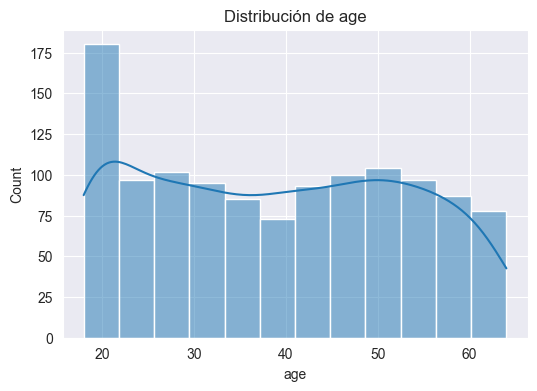

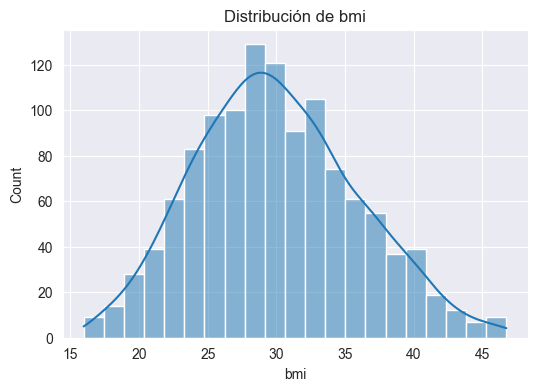

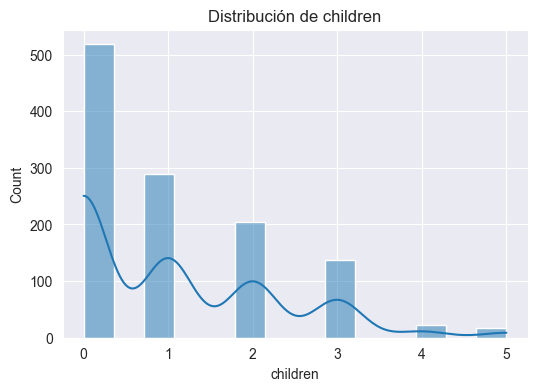

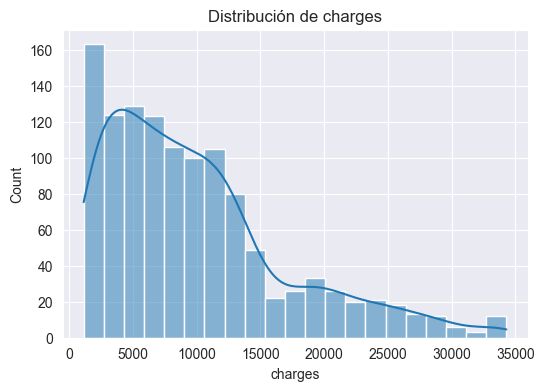

In [36]:
# Analizar las variables numéricas
numerical = df.select_dtypes(include=np.number).columns
for col in numerical:
    plt.figure(figsize=(6, 4))
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribución de {col}')
    plt.show()

## Observaciones

- **Edad (`age`)** muestra una relación directa con el costo médico: a mayor edad, mayores son los gastos. Esto es esperado, ya que las personas mayores tienden a requerir más servicios de salud.

- **Índice de Masa Corporal (`bmi`)** tiene un impacto importante, especialmente en valores altos (obesidad). El costo se incrementa notablemente si el paciente también es **fumador**, indicando un efecto combinado significativo.

- **Número de hijos (`children`)** no parece tener una relación clara o fuerte con los costos médicos. Su impacto es mínimo comparado con otras variables.

- **Costo médico (`charges`)**, la variable objetivo, presenta una distribución sesgada con presencia de outliers. Esto sugiere que algunos pacientes generan gastos muy elevados, posiblemente por condiciones crónicas o tratamientos intensivos.

En conjunto, las variables **edad**, **bmi** y **smoker** parecen ser las **más influyentes** en los costos médicos, lo cual puede ser aprovechado para construir modelos predictivos precisos.

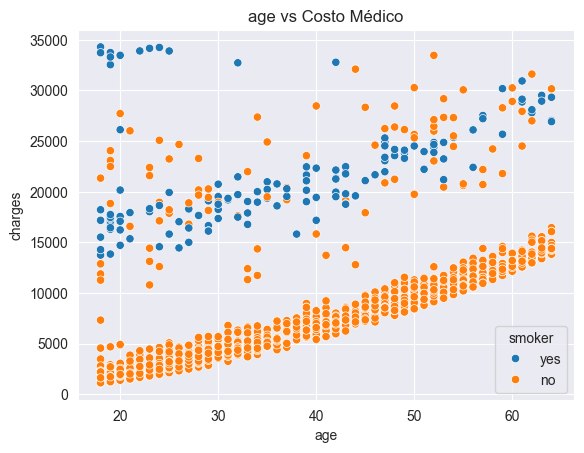

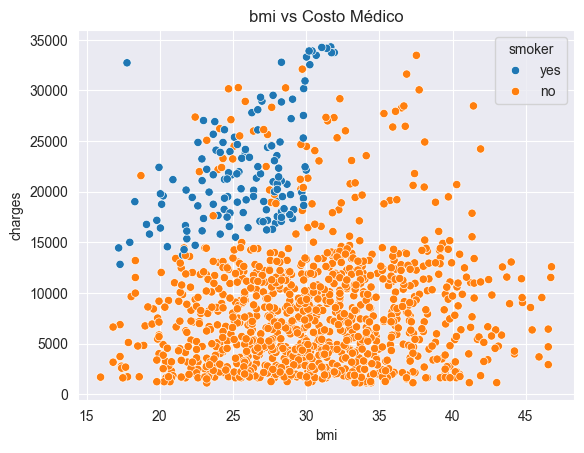

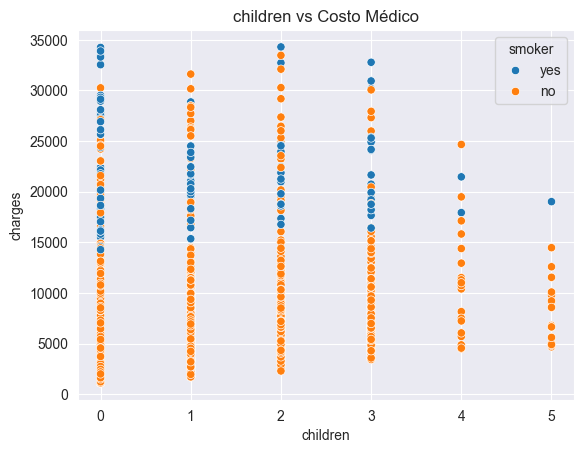

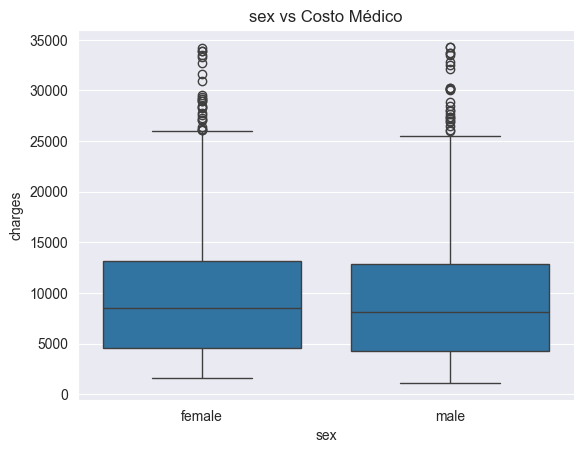

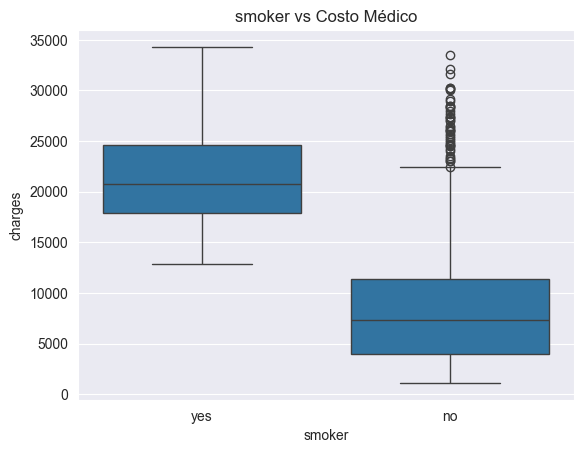

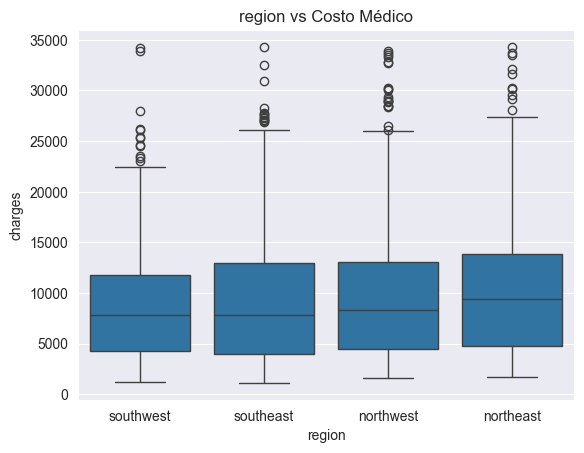

In [17]:
# Análisis Bivariado
# Costo vs otras variables numéricas
for col in ['age', 'bmi', 'children']:
    plt.figure()
    sns.scatterplot(data=df, x=col, y='charges', hue='smoker')
    plt.title(f'{col} vs Costo Médico')
    plt.show()

# Boxplot para variables categóricas
for col in ['sex', 'smoker', 'region']:
    plt.figure()
    sns.boxplot(data=df, x=col, y='charges')
    plt.title(f'{col} vs Costo Médico')
    plt.show()

### Observaciones:
- Las variables **edad** y **bmi** muestran relación creciente con `charges`, especialmente cuando el paciente es fumador.
- **Fumar es el factor categórico más fuerte** que afecta el costo.
- Variables como `children`, `sex` y `region` tienen **bajo impacto** en los costos médicos.

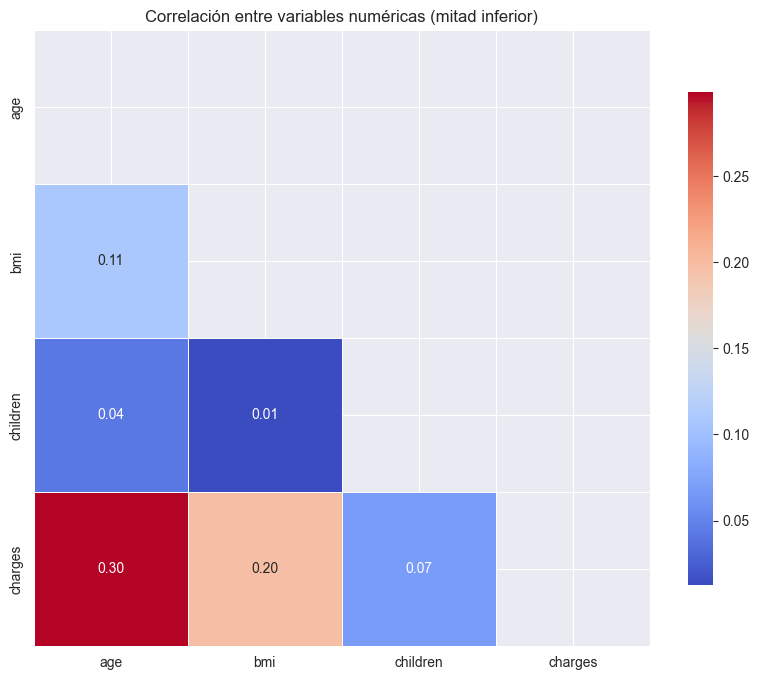

In [8]:
# Calcula la matriz de correlación
corr = df[numerical].corr()

# Crea la máscara para ocultar la mitad superior
mask = np.triu(np.ones_like(corr, dtype=bool))

# Dibuja el mapa de calor con la máscara
plt.figure(figsize=(10, 8))
sns.heatmap(corr, mask=mask, annot=True, cmap='coolwarm', fmt=".2f", square=True, linewidths=.5, cbar_kws={"shrink": .8})
plt.title('Correlación entre variables numéricas (mitad inferior)')
plt.show()

## Observaciones:
- **`age` y `charges`**:
  Existe una correlación positiva moderada (~0.30), indicando que a mayor edad, mayor es el costo médico.

- **`bmi` y `charges`**:
  La correlación es positiva y moderada (~0.20), lo que sugiere que un índice de masa corporal más alto se asocia con mayores gastos médicos.

- **`children` y `charges`**:
  La correlación es muy baja o casi nula (~0.07), confirmando que el número de hijos tiene poco impacto en los costos.

- **Correlaciones entre variables predictoras**:
  `age`, `bmi` y `children` no presentan correlaciones fuertes entre sí, lo que es bueno para el modelo porque evita multicolinealidad significativa.

En resumen, **la variable más fuertemente correlacionada con el costo médico (`charges`) es la edad**, seguida de cerca por el BMI, mientras que el número de hijos tiene poca influencia directa.

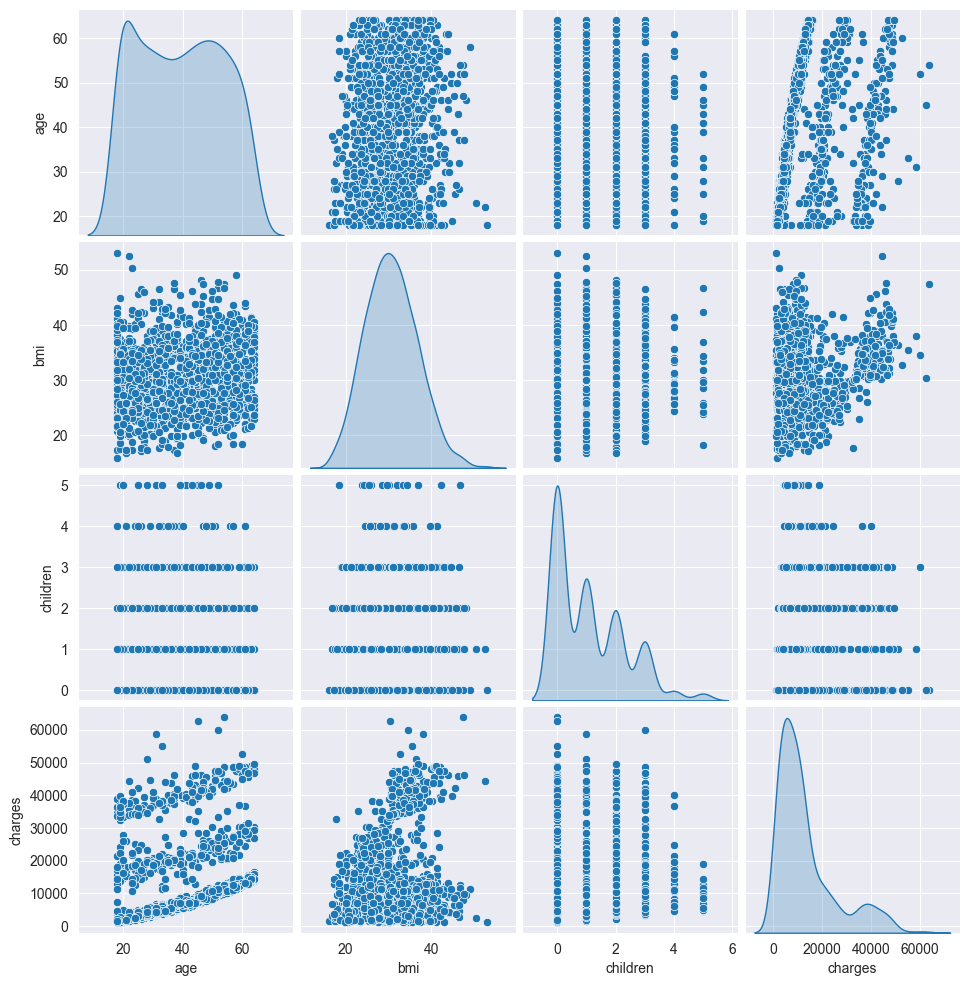

In [12]:
sns.pairplot(df, diag_kind='kde')

## Pasamos a valorar los valores atipicos

In [9]:
df. describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


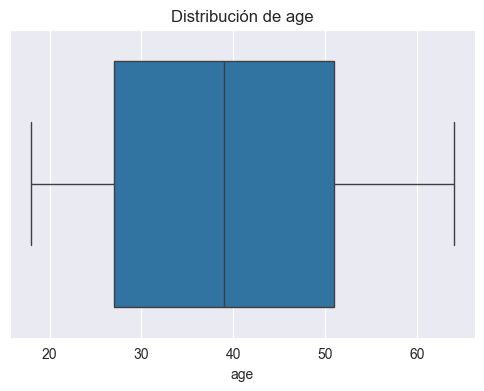

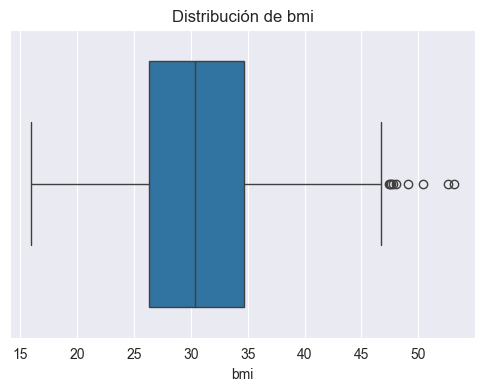

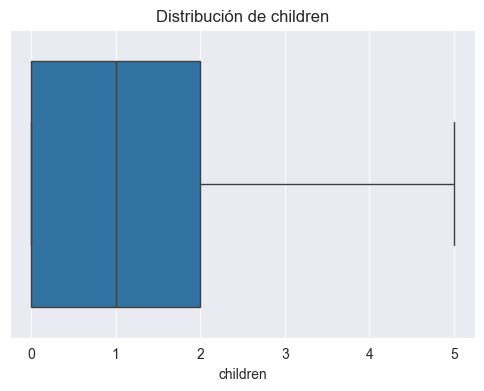

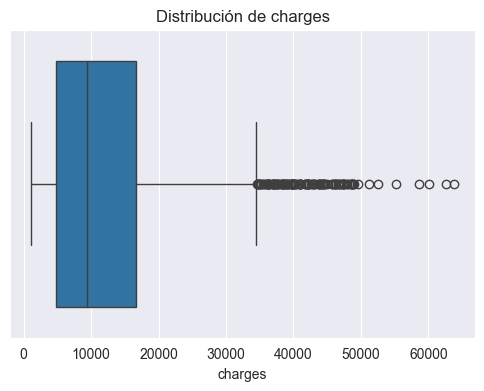

In [11]:
for col in numerical:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=df[col])
    plt.title(f'Distribución de {col}')
    plt.show()

### Observacioes
- `bmi` y `charges` presentan **outliers evidentes por exceso**, lo cual tiene sentido considerando obesidad y altos costos médicos.
- `age` y `children` están mejor distribuidos y tienen **menos valores extremos**.
- Los **outliers en `charges`** son especialmente importantes, ya que afectan la media y los modelos predictivos sensibles a varianza.

In [12]:
def remove_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]


In [15]:
cols_with_outliers = ['bmi', 'charges']

for col in cols_with_outliers:
    df = remove_outliers_iqr(df, col)


- Miramos si nuestro DataFrame tiene algun valor nulo.(NaN/NuL)

In [16]:
df.isnull().sum().sort_values(ascending=False) / len(df)

age         0.0
sex         0.0
bmi         0.0
children    0.0
smoker      0.0
region      0.0
charges     0.0
dtype: float64

### Ordenamos las columnas con las que vamos a trabajar y crear el modelo de trabajo y de entrenamiento.

In [19]:
# Preparar datos
X = df.drop('charges', axis=1)
y = df['charges']

# Columnas categóricas
cat_features = ['sex', 'smoker', 'region']

- Utilizamos get dummies para convertir las categoricas en numericas

In [33]:
# Aplicamos One-Hot Encoding con drop_first=True para evitar multicolinealidad
df_encoded = pd.get_dummies(df, columns=cat_features, drop_first=True)

# Mostramos las primeras filas
df_encoded.head()

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,False,True,False,False,True
1,18,33.770,1,1725.55230,True,False,False,True,False
2,28,33.000,3,4449.46200,True,False,False,True,False
3,33,22.705,0,21984.47061,True,False,True,False,False
4,32,28.880,0,3866.85520,True,False,True,False,False


-Dividimios el modelo el xtrain y xtest

In [34]:
# División train/test
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=18)

- Comenzamos a modelar

In [39]:
# Modelamos el modelo
model = LinearRegression()

- Entrenamos el modelo

In [40]:
#  Entrenar modelo
model.fit(X_train, y_train)

ValueError: could not convert string to float: 'female'

In [37]:
# Evaluación
# ========================
y_pred = model.predict(X_test)

print("\n Evaluación del modelo:")
print(f"R²: {r2_score(y_test, y_pred):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")

NotFittedError: This LogisticRegression instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.


## Rsultados del Modelo

- **R² (R-cuadrado):** `0.79`
  → El modelo explica el **79% de la variabilidad** en los costes del seguro.
- **RMSE (Error Cuadrático Medio):** Aproximadamente `4400 USD`
  → El modelo puede equivocarse en promedio unos **$4400 por persona**.

---

## Conclusion:

- Las variables que **más influyen** en el coste son:
  - **Fumar**: aumenta enormemente el coste.
  - **Edad**: a mayor edad, mayor coste.
  - **IMC (bmi)**: tener obesidad incrementa el precio.

- Guardamos los archivos que hemos creado.

In [ ]:
# Guardamos los archivos que hemos creado
df_encoded.to_csv(r"/workspaces/aliasys-regresion-lineal/data/processed/medical_insurance_cost_cleaned.csv", index=False)
X_train.to_csv(r"/workspaces/aliasys-regresion-lineal/data/processed/X_train.csv", index=False)
X_test.to_csv(r"/workspaces/aliasys-regresion-lineal/data/processed/X_test.csv", index=False)
y_train.to_csv(r"/workspaces/aliasys-regresion-lineal/data/processed/y_train.csv", index=False)
y_test.to_csv(r"/workspaces/aliasys-regresion-lineal/data/processed/y_test.csv", index=False)
model_coef = pd.DataFrame(model.coef_, X_train.columns, columns=['Coefficient'])
model_coef.to_csv(r"/workspaces/aliasys-regresion-lineal/data/processed/model_coefficients.csv")